In [1]:
import pandas as pd
import numpy as np 

from tqdm.auto import tqdm 

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns 
from pylab import rcParams 
import matplotlib.pyplot as plt 
from matplotlib import rc 

%matplotlib inline 
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42 



c:\Users\2260927\Anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "C:\\Sowmya\\Personal\\NLP\\NLP_Stuffs\\train.csv"

df = pd.read_csv(data_path)
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [3]:
df['CONTEXT'] = df['TITLE'] + ". " + df['ABSTRACT']
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,CONTEXT
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps. ...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network. Rotation...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


In [4]:
df.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance',
       'CONTEXT'],
      dtype='object')

In [5]:
df.drop(['ID', 'TITLE', 'ABSTRACT'], axis=1, inplace=True)

In [6]:
df = df[['CONTEXT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']]
df.head()

,CONTEXT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps. ...,1,0,0,0,0,0
1,Rotation Invariance Neural Network. Rotation...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,1,0,0,1,0,0


In [7]:
df.shape

(20972, 7)

In [8]:
df = df[:5000]

In [9]:
df.isnull().sum()

CONTEXT                 0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [10]:
train_df, test_df = train_test_split(df, test_size=0.05)

train_df.shape, test_df.shape

((4750, 7), (250, 7))

<Axes: >

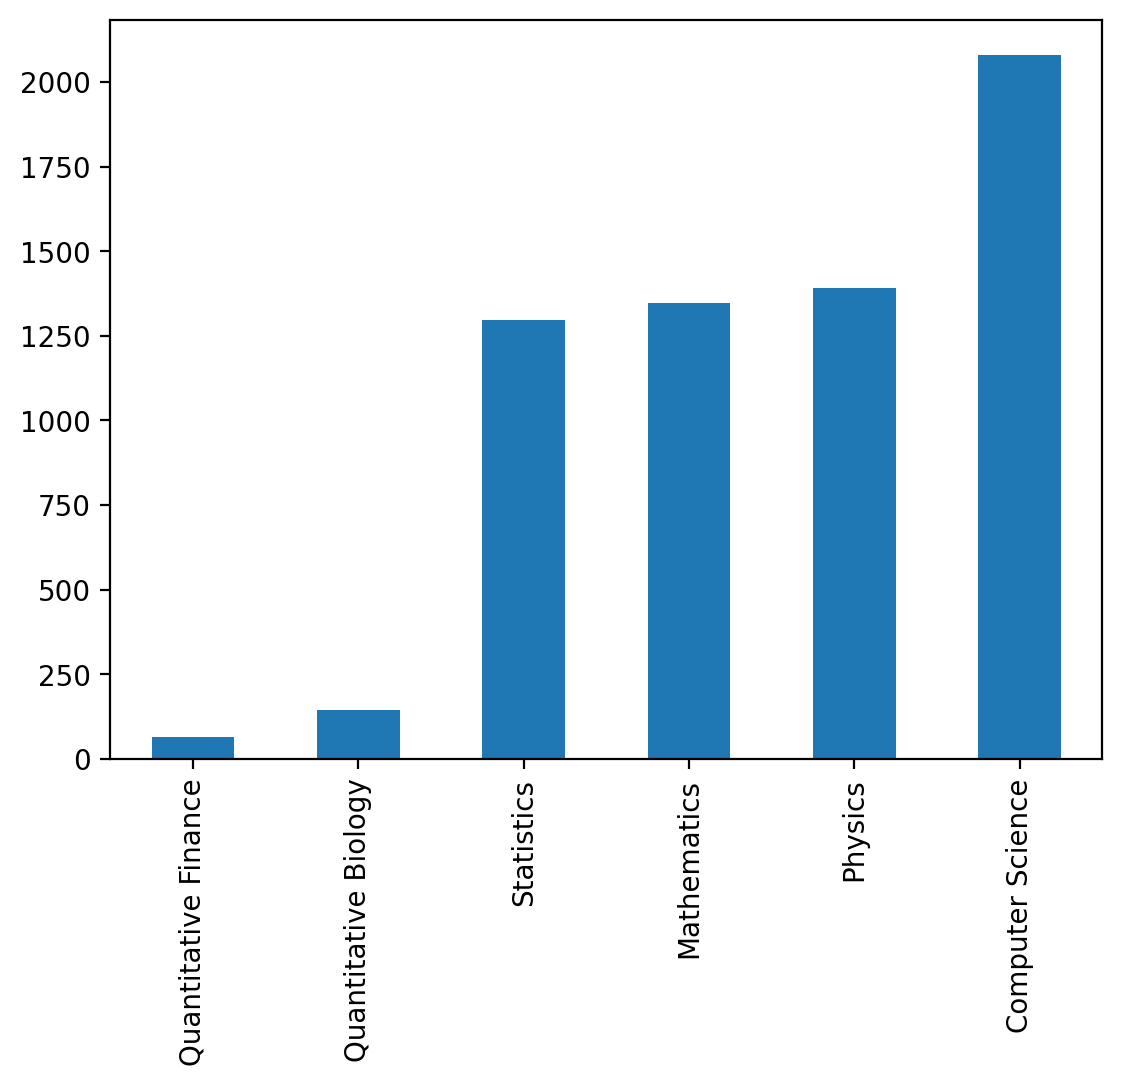

In [11]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind='bar')

<Axes: >

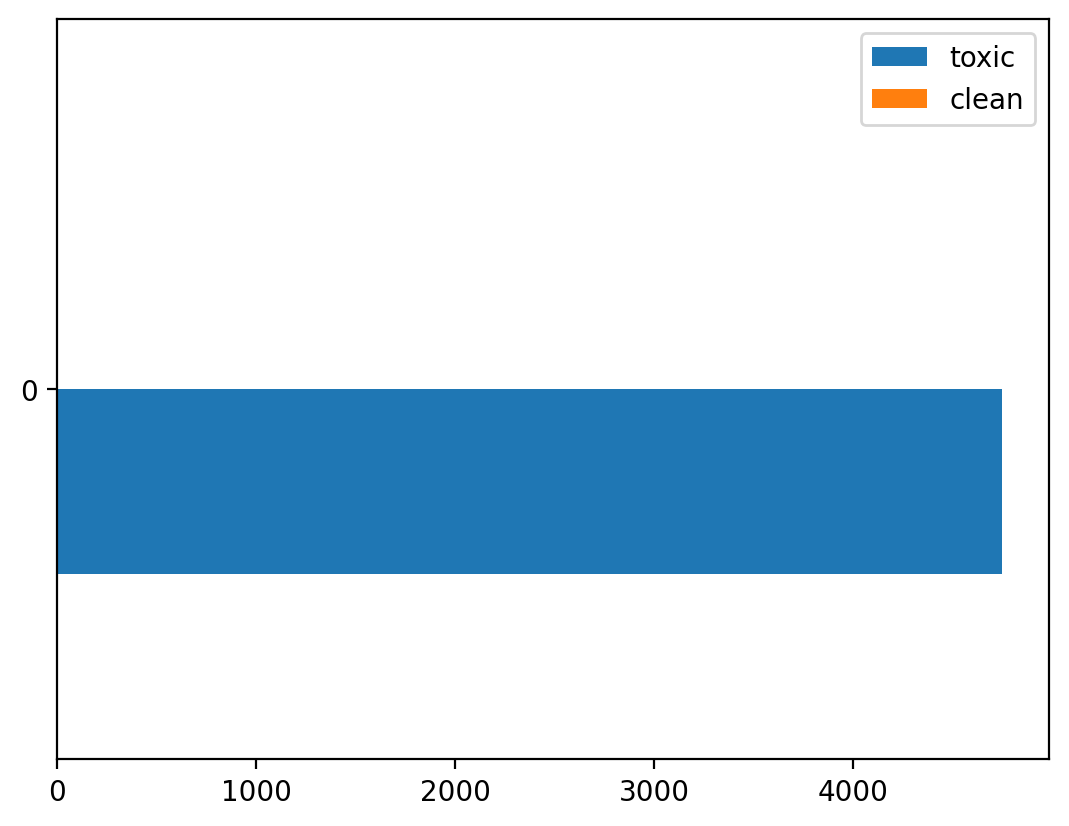

In [12]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
    toxic=[len(train_toxic)],
    clean=[len(train_clean)]
)).plot(kind='barh')

In [13]:
class ToxicCommentDataset:
    def __init__(self, df, tokenizer, max_len):
        self.df = df 
        self.tokenizer = tokenizer
        self.max_len = max_len 

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        data_row = self.df.iloc[index]

        comment_text = data_row.CONTEXT
        labels = data_row[LABEL_COLUMNS]

        encoding = self.tokenizer(
            comment_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            "comment_text": comment_text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.FloatTensor(labels)
        }

In [14]:
class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_length=128):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_length = max_token_length

    def setup(self, stage=None):
        self.train_dataset = ToxicCommentDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_length
        )

        self.test_dataset = ToxicCommentDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_length
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=0
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=0
        )

** ToxicCommentDataModule ** encapsulates all data loading logic adn returns the necessary data loaders. Let's create an instance of out data module.

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

c:\Users\2260927\Anaconda3\envs\deeplearning\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
N_EPOCHS = 2
BATCH_SIZE = 12
MAX_TOKEN_LENGTH =512
BERT_MODEL_NAME = "bert-base-uncased"
n_classes = len(LABEL_COLUMNS)

data_module = ToxicCommentDataModule(
    train_df=train_df,
    test_df=test_df,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    max_token_length=MAX_TOKEN_LENGTH
)

In [17]:
class ToxicCommentTagger(pl.LightningModule):
    def __init__(self, n_classes, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {
            "loss": loss,
            "predictions": outputs,
            "labels": labels
        }
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def on_train_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_training_steps=self.n_training_steps,
            num_warmup_steps=self.n_warmup_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )


#### Optimizer scheduler

In [18]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps=20
total_training_steps=100

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_training_steps=total_training_steps,
    num_warmup_steps=warmup_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

c:\Users\2260927\Anaconda3\envs\deeplearning\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


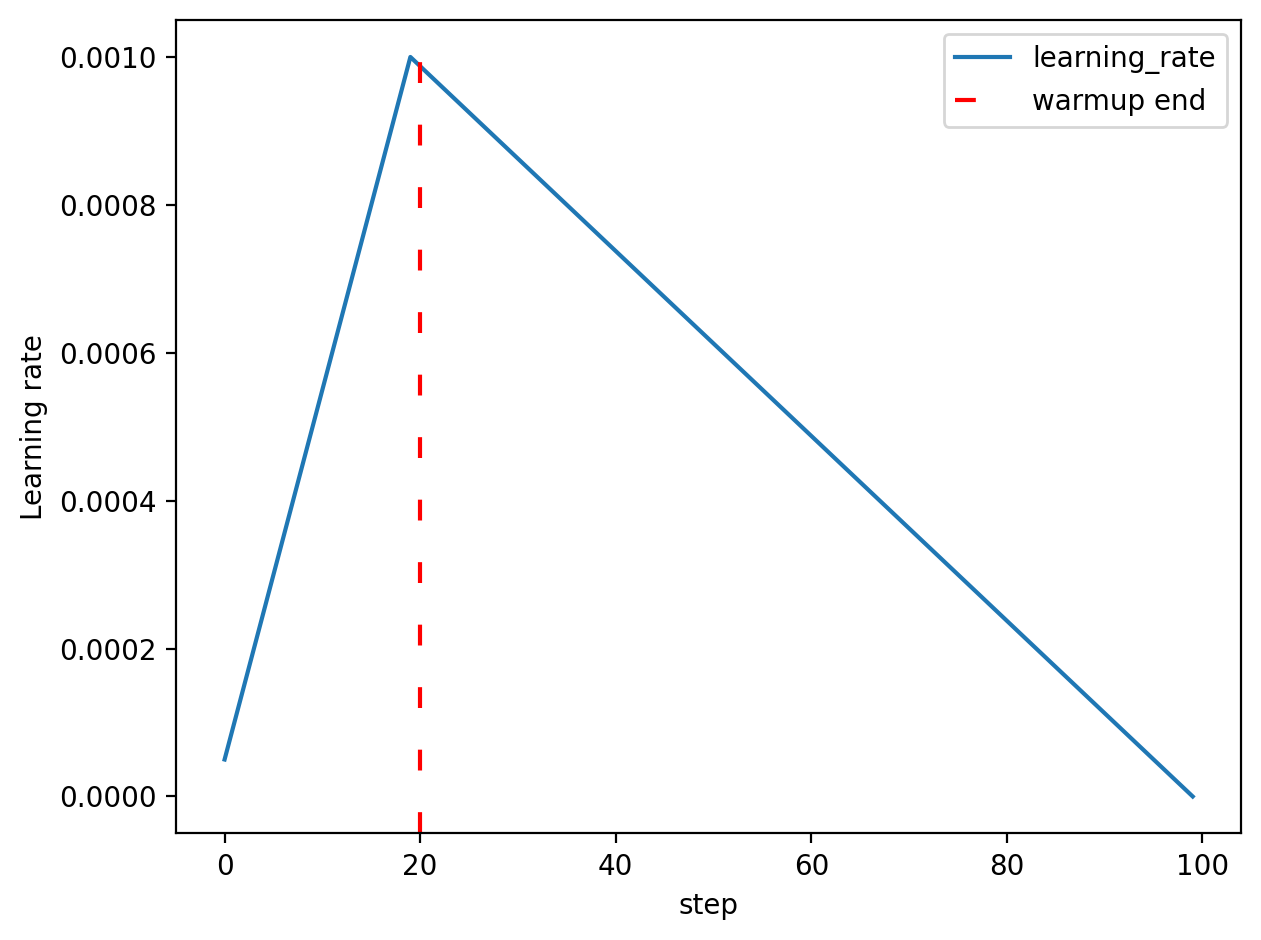

In [19]:
plt.plot(learning_rate_history, label="learning_rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("step")
plt.ylabel("Learning rate")
plt.tight_layout();

==========================

In [20]:
steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [21]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(158, 790)

In [22]:
model = ToxicCommentTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

# Evalusation

In [23]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
    [10.345, 1.0879, 1.5843, 0.0345, 15.7232, 1.09534]
)

labels = torch.FloatTensor(
    [1., 0., 0., 0., 1., 0.]
)

In [24]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7480, 0.8298, 0.5086, 1.0000, 0.7494])

In [25]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8739)

We can use same approach to calculate the loss of the prediciton

# Training

In [26]:
# ! rm -rf lightning_logs/
# ! rm -rf checkpoints/

In [27]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 12240), started 0:19:32 ago. (Use '!kill 12240' to kill it.)

In [28]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [29]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [30]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [31]:
trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback, checkpoint_callback],
    max_epochs=N_EPOCHS,
    enable_progress_bar=True
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(model, data_module)


  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | bert       | BertModel | 109 M  | eval 
1 | classifier | Linear    | 4.6 K  | train
2 | criterion  | BCELoss   | 0      | train
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.947   Total estimated model params size (MB)
2         Modules in train mode
228       Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\2260927\Anaconda3\envs\deeplearning\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:13<00:13,  0.08it/s]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

c:\Users\2260927\Anaconda3\envs\deeplearning\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/396 [00:00<?, ?it/s] 

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   0%|          | 1/396 [01:01<6:41:49,  0.02it/s, v_num=0, train_loss=0.683]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   1%|          | 2/396 [01:41<5:31:54,  0.02it/s, v_num=0, train_loss=0.710]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   1%|          | 3/396 [02:18<5:01:56,  0.02it/s, v_num=0, train_loss=0.659]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   1%|          | 4/396 [03:01<4:56:21,  0.02it/s, v_num=0, train_loss=0.694]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   1%|▏         | 5/396 [03:44<4:51:58,  0.02it/s, v_num=0, train_loss=0.726]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   2%|▏         | 6/396 [04:21<4:43:27,  0.02it/s, v_num=0, train_loss=0.761]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   2%|▏         | 7/396 [04:49<4:28:11,  0.02it/s, v_num=0, train_loss=0.705]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   2%|▏         | 8/396 [05:17<4:16:32,  0.03it/s, v_num=0, train_loss=0.724]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   2%|▏         | 9/396 [05:46<4:08:07,  0.03it/s, v_num=0, train_loss=0.652]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   3%|▎         | 10/396 [06:13<4:00:22,  0.03it/s, v_num=0, train_loss=0.683]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   3%|▎         | 11/396 [06:40<3:53:39,  0.03it/s, v_num=0, train_loss=0.721]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   3%|▎         | 12/396 [07:07<3:48:03,  0.03it/s, v_num=0, train_loss=0.743]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   3%|▎         | 13/396 [07:35<3:43:32,  0.03it/s, v_num=0, train_loss=0.673]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   4%|▎         | 14/396 [08:00<3:38:38,  0.03it/s, v_num=0, train_loss=0.736]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   4%|▍         | 15/396 [08:28<3:35:10,  0.03it/s, v_num=0, train_loss=0.694]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   4%|▍         | 16/396 [08:55<3:32:09,  0.03it/s, v_num=0, train_loss=0.666]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   4%|▍         | 17/396 [09:23<3:29:24,  0.03it/s, v_num=0, train_loss=0.663]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   5%|▍         | 18/396 [09:51<3:27:06,  0.03it/s, v_num=0, train_loss=0.659]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   5%|▍         | 19/396 [10:21<3:25:24,  0.03it/s, v_num=0, train_loss=0.646]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   5%|▌         | 20/396 [10:49<3:23:30,  0.03it/s, v_num=0, train_loss=0.637]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   5%|▌         | 21/396 [11:27<3:24:34,  0.03it/s, v_num=0, train_loss=0.636]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   6%|▌         | 22/396 [12:13<3:27:42,  0.03it/s, v_num=0, train_loss=0.623]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   6%|▌         | 23/396 [13:28<3:38:35,  0.03it/s, v_num=0, train_loss=0.665]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   6%|▌         | 24/396 [14:36<3:46:23,  0.03it/s, v_num=0, train_loss=0.629]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   6%|▋         | 25/396 [16:08<3:59:28,  0.03it/s, v_num=0, train_loss=0.613]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   7%|▋         | 26/396 [17:40<4:11:32,  0.02it/s, v_num=0, train_loss=0.694]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   7%|▋         | 27/396 [18:23<4:11:20,  0.02it/s, v_num=0, train_loss=0.729]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   7%|▋         | 28/396 [19:00<4:09:46,  0.02it/s, v_num=0, train_loss=0.619]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   7%|▋         | 29/396 [19:58<4:12:43,  0.02it/s, v_num=0, train_loss=0.623]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   8%|▊         | 30/396 [21:04<4:17:09,  0.02it/s, v_num=0, train_loss=0.652]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   8%|▊         | 31/396 [21:49<4:17:00,  0.02it/s, v_num=0, train_loss=0.652]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   8%|▊         | 32/396 [22:34<4:16:42,  0.02it/s, v_num=0, train_loss=0.662]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   8%|▊         | 33/396 [23:34<4:19:23,  0.02it/s, v_num=0, train_loss=0.674]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   9%|▊         | 34/396 [24:53<4:25:05,  0.02it/s, v_num=0, train_loss=0.648]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   9%|▉         | 35/396 [26:05<4:29:08,  0.02it/s, v_num=0, train_loss=0.635]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   9%|▉         | 36/396 [27:07<4:31:19,  0.02it/s, v_num=0, train_loss=0.629]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:   9%|▉         | 37/396 [28:31<4:36:45,  0.02it/s, v_num=0, train_loss=0.612]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  10%|▉         | 38/396 [29:24<4:37:07,  0.02it/s, v_num=0, train_loss=0.596]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  10%|▉         | 39/396 [29:55<4:33:52,  0.02it/s, v_num=0, train_loss=0.620]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  10%|█         | 40/396 [30:23<4:30:28,  0.02it/s, v_num=0, train_loss=0.597]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  10%|█         | 41/396 [30:48<4:26:45,  0.02it/s, v_num=0, train_loss=0.589]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  11%|█         | 42/396 [31:14<4:23:19,  0.02it/s, v_num=0, train_loss=0.582]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  11%|█         | 43/396 [31:40<4:20:05,  0.02it/s, v_num=0, train_loss=0.582]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  11%|█         | 44/396 [32:07<4:16:56,  0.02it/s, v_num=0, train_loss=0.583]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  11%|█▏        | 45/396 [32:31<4:13:39,  0.02it/s, v_num=0, train_loss=0.571]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  12%|█▏        | 46/396 [32:55<4:10:32,  0.02it/s, v_num=0, train_loss=0.566]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  12%|█▏        | 47/396 [33:19<4:07:29,  0.02it/s, v_num=0, train_loss=0.558]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  12%|█▏        | 48/396 [33:44<4:04:36,  0.02it/s, v_num=0, train_loss=0.566]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  12%|█▏        | 49/396 [34:15<4:02:34,  0.02it/s, v_num=0, train_loss=0.553]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  13%|█▎        | 50/396 [34:49<4:01:00,  0.02it/s, v_num=0, train_loss=0.569]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  13%|█▎        | 51/396 [35:16<3:58:39,  0.02it/s, v_num=0, train_loss=0.548]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  13%|█▎        | 52/396 [35:42<3:56:14,  0.02it/s, v_num=0, train_loss=0.527]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  13%|█▎        | 53/396 [36:07<3:53:47,  0.02it/s, v_num=0, train_loss=0.557]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  14%|█▎        | 54/396 [36:32<3:51:24,  0.02it/s, v_num=0, train_loss=0.523]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  14%|█▍        | 55/396 [36:57<3:49:09,  0.02it/s, v_num=0, train_loss=0.511]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  14%|█▍        | 56/396 [37:22<3:46:53,  0.02it/s, v_num=0, train_loss=0.491]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  14%|█▍        | 57/396 [37:47<3:44:46,  0.03it/s, v_num=0, train_loss=0.499]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  15%|█▍        | 58/396 [38:13<3:42:44,  0.03it/s, v_num=0, train_loss=0.532]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  15%|█▍        | 59/396 [38:39<3:40:50,  0.03it/s, v_num=0, train_loss=0.544]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  15%|█▌        | 60/396 [39:06<3:38:58,  0.03it/s, v_num=0, train_loss=0.503]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  15%|█▌        | 61/396 [39:29<3:36:55,  0.03it/s, v_num=0, train_loss=0.489]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  16%|█▌        | 62/396 [39:56<3:35:08,  0.03it/s, v_num=0, train_loss=0.463]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  16%|█▌        | 63/396 [40:22<3:33:25,  0.03it/s, v_num=0, train_loss=0.492]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  16%|█▌        | 64/396 [40:47<3:31:36,  0.03it/s, v_num=0, train_loss=0.522]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  16%|█▋        | 65/396 [41:13<3:29:55,  0.03it/s, v_num=0, train_loss=0.481]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  17%|█▋        | 66/396 [41:38<3:28:14,  0.03it/s, v_num=0, train_loss=0.522]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  17%|█▋        | 67/396 [42:04<3:26:35,  0.03it/s, v_num=0, train_loss=0.495]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  17%|█▋        | 68/396 [42:30<3:25:01,  0.03it/s, v_num=0, train_loss=0.454]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  17%|█▋        | 69/396 [42:55<3:23:23,  0.03it/s, v_num=0, train_loss=0.501]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  18%|█▊        | 70/396 [43:20<3:21:48,  0.03it/s, v_num=0, train_loss=0.461]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  18%|█▊        | 71/396 [43:45<3:20:20,  0.03it/s, v_num=0, train_loss=0.466]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  18%|█▊        | 72/396 [44:11<3:18:53,  0.03it/s, v_num=0, train_loss=0.442]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  18%|█▊        | 73/396 [44:37<3:17:25,  0.03it/s, v_num=0, train_loss=0.501]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  19%|█▊        | 74/396 [45:03<3:16:04,  0.03it/s, v_num=0, train_loss=0.448]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  19%|█▉        | 75/396 [45:28<3:14:39,  0.03it/s, v_num=0, train_loss=0.438]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  19%|█▉        | 76/396 [45:55<3:13:22,  0.03it/s, v_num=0, train_loss=0.484]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  19%|█▉        | 77/396 [46:19<3:11:53,  0.03it/s, v_num=0, train_loss=0.431]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  20%|█▉        | 78/396 [46:43<3:10:31,  0.03it/s, v_num=0, train_loss=0.442]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  20%|█▉        | 79/396 [47:09<3:09:13,  0.03it/s, v_num=0, train_loss=0.427]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  20%|██        | 80/396 [47:34<3:07:54,  0.03it/s, v_num=0, train_loss=0.410]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  20%|██        | 81/396 [48:00<3:06:40,  0.03it/s, v_num=0, train_loss=0.461]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  21%|██        | 82/396 [48:25<3:05:25,  0.03it/s, v_num=0, train_loss=0.450]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  21%|██        | 83/396 [48:50<3:04:11,  0.03it/s, v_num=0, train_loss=0.432]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  21%|██        | 84/396 [49:13<3:02:51,  0.03it/s, v_num=0, train_loss=0.445]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  21%|██▏       | 85/396 [49:39<3:01:39,  0.03it/s, v_num=0, train_loss=0.404]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  22%|██▏       | 86/396 [50:05<3:00:34,  0.03it/s, v_num=0, train_loss=0.424]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  22%|██▏       | 87/396 [50:28<2:59:17,  0.03it/s, v_num=0, train_loss=0.438]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  22%|██▏       | 88/396 [50:52<2:58:05,  0.03it/s, v_num=0, train_loss=0.406]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  22%|██▏       | 89/396 [51:20<2:57:04,  0.03it/s, v_num=0, train_loss=0.392]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  23%|██▎       | 90/396 [51:45<2:55:57,  0.03it/s, v_num=0, train_loss=0.408]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  23%|██▎       | 91/396 [52:11<2:54:55,  0.03it/s, v_num=0, train_loss=0.446]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  23%|██▎       | 92/396 [52:37<2:53:54,  0.03it/s, v_num=0, train_loss=0.428]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  23%|██▎       | 93/396 [53:03<2:52:52,  0.03it/s, v_num=0, train_loss=0.437]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  24%|██▎       | 94/396 [53:32<2:51:59,  0.03it/s, v_num=0, train_loss=0.417]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  24%|██▍       | 95/396 [53:58<2:50:59,  0.03it/s, v_num=0, train_loss=0.394]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  24%|██▍       | 96/396 [54:24<2:50:01,  0.03it/s, v_num=0, train_loss=0.357]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  24%|██▍       | 97/396 [54:49<2:48:58,  0.03it/s, v_num=0, train_loss=0.417]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  25%|██▍       | 98/396 [55:13<2:47:56,  0.03it/s, v_num=0, train_loss=0.486]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  25%|██▌       | 99/396 [55:38<2:46:56,  0.03it/s, v_num=0, train_loss=0.370]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  25%|██▌       | 100/396 [56:01<2:45:50,  0.03it/s, v_num=0, train_loss=0.380]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  26%|██▌       | 101/396 [56:27<2:44:53,  0.03it/s, v_num=0, train_loss=0.340]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  26%|██▌       | 102/396 [56:49<2:43:47,  0.03it/s, v_num=0, train_loss=0.389]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  26%|██▌       | 103/396 [57:11<2:42:42,  0.03it/s, v_num=0, train_loss=0.372]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  26%|██▋       | 104/396 [57:39<2:41:52,  0.03it/s, v_num=0, train_loss=0.398]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  27%|██▋       | 105/396 [58:03<2:40:53,  0.03it/s, v_num=0, train_loss=0.359]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  27%|██▋       | 106/396 [58:28<2:39:58,  0.03it/s, v_num=0, train_loss=0.398]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  27%|██▋       | 107/396 [58:53<2:39:04,  0.03it/s, v_num=0, train_loss=0.396]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  27%|██▋       | 108/396 [59:16<2:38:05,  0.03it/s, v_num=0, train_loss=0.354]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  28%|██▊       | 109/396 [59:40<2:37:07,  0.03it/s, v_num=0, train_loss=0.388]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  28%|██▊       | 110/396 [1:00:03<2:36:10,  0.03it/s, v_num=0, train_loss=0.394]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  28%|██▊       | 111/396 [1:00:29<2:35:18,  0.03it/s, v_num=0, train_loss=0.368]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  28%|██▊       | 112/396 [1:00:53<2:34:25,  0.03it/s, v_num=0, train_loss=0.356]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  29%|██▊       | 113/396 [1:01:19<2:33:33,  0.03it/s, v_num=0, train_loss=0.368]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  29%|██▉       | 114/396 [1:01:42<2:32:39,  0.03it/s, v_num=0, train_loss=0.346]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  29%|██▉       | 115/396 [1:02:06<2:31:46,  0.03it/s, v_num=0, train_loss=0.356]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  29%|██▉       | 116/396 [1:02:31<2:30:56,  0.03it/s, v_num=0, train_loss=0.371]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  30%|██▉       | 117/396 [1:02:56<2:30:06,  0.03it/s, v_num=0, train_loss=0.412]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  30%|██▉       | 118/396 [1:03:21<2:29:15,  0.03it/s, v_num=0, train_loss=0.335]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  30%|███       | 119/396 [1:03:44<2:28:21,  0.03it/s, v_num=0, train_loss=0.337]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  30%|███       | 120/396 [1:04:09<2:27:33,  0.03it/s, v_num=0, train_loss=0.347]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  31%|███       | 121/396 [1:04:31<2:26:39,  0.03it/s, v_num=0, train_loss=0.379]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  31%|███       | 122/396 [1:04:54<2:25:45,  0.03it/s, v_num=0, train_loss=0.304]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  31%|███       | 123/396 [1:05:17<2:24:53,  0.03it/s, v_num=0, train_loss=0.315]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  31%|███▏      | 124/396 [1:05:39<2:24:01,  0.03it/s, v_num=0, train_loss=0.345]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  32%|███▏      | 125/396 [1:06:02<2:23:11,  0.03it/s, v_num=0, train_loss=0.320]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  32%|███▏      | 126/396 [1:06:27<2:22:25,  0.03it/s, v_num=0, train_loss=0.335]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  32%|███▏      | 127/396 [1:06:51<2:21:36,  0.03it/s, v_num=0, train_loss=0.338]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  32%|███▏      | 128/396 [1:07:14<2:20:47,  0.03it/s, v_num=0, train_loss=0.330]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  33%|███▎      | 129/396 [1:07:36<2:19:55,  0.03it/s, v_num=0, train_loss=0.313]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  33%|███▎      | 130/396 [1:07:59<2:19:07,  0.03it/s, v_num=0, train_loss=0.349]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  33%|███▎      | 131/396 [1:08:23<2:18:20,  0.03it/s, v_num=0, train_loss=0.336]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  33%|███▎      | 132/396 [1:08:46<2:17:33,  0.03it/s, v_num=0, train_loss=0.335]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  34%|███▎      | 133/396 [1:09:11<2:16:49,  0.03it/s, v_num=0, train_loss=0.306]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  34%|███▍      | 134/396 [1:09:33<2:16:00,  0.03it/s, v_num=0, train_loss=0.271]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  34%|███▍      | 135/396 [1:09:59<2:15:19,  0.03it/s, v_num=0, train_loss=0.296]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  34%|███▍      | 136/396 [1:10:25<2:14:39,  0.03it/s, v_num=0, train_loss=0.465]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  35%|███▍      | 137/396 [1:10:48<2:13:52,  0.03it/s, v_num=0, train_loss=0.305]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  35%|███▍      | 138/396 [1:11:12<2:13:08,  0.03it/s, v_num=0, train_loss=0.371]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  35%|███▌      | 139/396 [1:11:35<2:12:22,  0.03it/s, v_num=0, train_loss=0.395]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  35%|███▌      | 140/396 [1:11:58<2:11:37,  0.03it/s, v_num=0, train_loss=0.330]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  36%|███▌      | 141/396 [1:12:25<2:10:58,  0.03it/s, v_num=0, train_loss=0.411]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  36%|███▌      | 142/396 [1:12:49<2:10:16,  0.03it/s, v_num=0, train_loss=0.336]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  36%|███▌      | 143/396 [1:13:13<2:09:32,  0.03it/s, v_num=0, train_loss=0.443]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  36%|███▋      | 144/396 [1:13:38<2:08:52,  0.03it/s, v_num=0, train_loss=0.301]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  37%|███▋      | 145/396 [1:14:00<2:08:06,  0.03it/s, v_num=0, train_loss=0.355]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  37%|███▋      | 146/396 [1:14:23<2:07:22,  0.03it/s, v_num=0, train_loss=0.330]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  37%|███▋      | 147/396 [1:14:45<2:06:38,  0.03it/s, v_num=0, train_loss=0.281]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  37%|███▋      | 148/396 [1:15:07<2:05:53,  0.03it/s, v_num=0, train_loss=0.302]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  38%|███▊      | 149/396 [1:15:30<2:05:10,  0.03it/s, v_num=0, train_loss=0.394]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  38%|███▊      | 150/396 [1:15:53<2:04:27,  0.03it/s, v_num=0, train_loss=0.328]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  38%|███▊      | 151/396 [1:16:16<2:03:45,  0.03it/s, v_num=0, train_loss=0.327]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  38%|███▊      | 152/396 [1:16:42<2:03:08,  0.03it/s, v_num=0, train_loss=0.308]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  39%|███▊      | 153/396 [1:17:07<2:02:29,  0.03it/s, v_num=0, train_loss=0.266]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  39%|███▉      | 154/396 [1:17:31<2:01:50,  0.03it/s, v_num=0, train_loss=0.342]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  39%|███▉      | 155/396 [1:17:56<2:01:11,  0.03it/s, v_num=0, train_loss=0.224]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  39%|███▉      | 156/396 [1:18:20<2:00:31,  0.03it/s, v_num=0, train_loss=0.359]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  40%|███▉      | 157/396 [1:18:45<1:59:53,  0.03it/s, v_num=0, train_loss=0.298]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  40%|███▉      | 158/396 [1:19:10<1:59:15,  0.03it/s, v_num=0, train_loss=0.380]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  40%|████      | 159/396 [1:19:34<1:58:35,  0.03it/s, v_num=0, train_loss=0.295]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  40%|████      | 160/396 [1:19:57<1:57:55,  0.03it/s, v_num=0, train_loss=0.281]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  41%|████      | 161/396 [1:20:21<1:57:17,  0.03it/s, v_num=0, train_loss=0.377]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  41%|████      | 162/396 [1:20:45<1:56:39,  0.03it/s, v_num=0, train_loss=0.315]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  41%|████      | 163/396 [1:21:10<1:56:02,  0.03it/s, v_num=0, train_loss=0.260]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  41%|████▏     | 164/396 [1:21:34<1:55:23,  0.03it/s, v_num=0, train_loss=0.270]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  42%|████▏     | 165/396 [1:21:58<1:54:45,  0.03it/s, v_num=0, train_loss=0.328]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  42%|████▏     | 166/396 [1:22:21<1:54:06,  0.03it/s, v_num=0, train_loss=0.186]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  42%|████▏     | 167/396 [1:22:44<1:53:28,  0.03it/s, v_num=0, train_loss=0.357]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  42%|████▏     | 168/396 [1:23:10<1:52:52,  0.03it/s, v_num=0, train_loss=0.263]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  43%|████▎     | 169/396 [1:23:32<1:52:12,  0.03it/s, v_num=0, train_loss=0.340]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  43%|████▎     | 170/396 [1:23:57<1:51:36,  0.03it/s, v_num=0, train_loss=0.320]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  43%|████▎     | 171/396 [1:24:22<1:51:01,  0.03it/s, v_num=0, train_loss=0.270]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  43%|████▎     | 172/396 [1:24:44<1:50:21,  0.03it/s, v_num=0, train_loss=0.261]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  44%|████▎     | 173/396 [1:25:07<1:49:43,  0.03it/s, v_num=0, train_loss=0.311]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  44%|████▍     | 174/396 [1:25:29<1:49:04,  0.03it/s, v_num=0, train_loss=0.312]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  44%|████▍     | 175/396 [1:25:51<1:48:25,  0.03it/s, v_num=0, train_loss=0.253]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  44%|████▍     | 176/396 [1:26:14<1:47:48,  0.03it/s, v_num=0, train_loss=0.256]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  45%|████▍     | 177/396 [1:26:37<1:47:10,  0.03it/s, v_num=0, train_loss=0.299]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  45%|████▍     | 178/396 [1:26:59<1:46:32,  0.03it/s, v_num=0, train_loss=0.255]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  45%|████▌     | 179/396 [1:27:22<1:45:55,  0.03it/s, v_num=0, train_loss=0.305]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  45%|████▌     | 180/396 [1:27:43<1:45:16,  0.03it/s, v_num=0, train_loss=0.259]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  46%|████▌     | 181/396 [1:28:10<1:44:44,  0.03it/s, v_num=0, train_loss=0.289]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  46%|████▌     | 182/396 [1:28:35<1:44:10,  0.03it/s, v_num=0, train_loss=0.220]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  46%|████▌     | 183/396 [1:28:58<1:43:33,  0.03it/s, v_num=0, train_loss=0.246]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  46%|████▋     | 184/396 [1:29:22<1:42:58,  0.03it/s, v_num=0, train_loss=0.309]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  47%|████▋     | 185/396 [1:29:45<1:42:22,  0.03it/s, v_num=0, train_loss=0.296]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  47%|████▋     | 186/396 [1:30:10<1:41:48,  0.03it/s, v_num=0, train_loss=0.313]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  47%|████▋     | 187/396 [1:30:36<1:41:15,  0.03it/s, v_num=0, train_loss=0.254]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  47%|████▋     | 188/396 [1:31:00<1:40:41,  0.03it/s, v_num=0, train_loss=0.269]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  48%|████▊     | 189/396 [1:31:23<1:40:06,  0.03it/s, v_num=0, train_loss=0.325]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  48%|████▊     | 190/396 [1:31:48<1:39:32,  0.03it/s, v_num=0, train_loss=0.231]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  48%|████▊     | 191/396 [1:32:15<1:39:01,  0.03it/s, v_num=0, train_loss=0.271]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  48%|████▊     | 192/396 [1:32:48<1:38:36,  0.03it/s, v_num=0, train_loss=0.370]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  49%|████▊     | 193/396 [1:33:13<1:38:02,  0.03it/s, v_num=0, train_loss=0.238]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  49%|████▉     | 194/396 [1:33:37<1:37:29,  0.03it/s, v_num=0, train_loss=0.295]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  49%|████▉     | 195/396 [1:34:00<1:36:54,  0.03it/s, v_num=0, train_loss=0.201]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  49%|████▉     | 196/396 [1:34:23<1:36:18,  0.03it/s, v_num=0, train_loss=0.208]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  50%|████▉     | 197/396 [1:34:46<1:35:44,  0.03it/s, v_num=0, train_loss=0.180]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  50%|█████     | 198/396 [1:35:11<1:35:11,  0.03it/s, v_num=0, train_loss=0.188]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  50%|█████     | 199/396 [1:35:33<1:34:36,  0.03it/s, v_num=0, train_loss=0.183]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  51%|█████     | 200/396 [1:35:55<1:34:00,  0.03it/s, v_num=0, train_loss=0.207]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  51%|█████     | 201/396 [1:36:18<1:33:26,  0.03it/s, v_num=0, train_loss=0.258]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  51%|█████     | 202/396 [1:36:41<1:32:51,  0.03it/s, v_num=0, train_loss=0.218]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  51%|█████▏    | 203/396 [1:37:03<1:32:16,  0.03it/s, v_num=0, train_loss=0.218]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  52%|█████▏    | 204/396 [1:37:26<1:31:42,  0.03it/s, v_num=0, train_loss=0.380]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  52%|█████▏    | 205/396 [1:37:48<1:31:07,  0.03it/s, v_num=0, train_loss=0.215]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  52%|█████▏    | 206/396 [1:38:10<1:30:33,  0.03it/s, v_num=0, train_loss=0.307]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  52%|█████▏    | 207/396 [1:38:34<1:30:00,  0.03it/s, v_num=0, train_loss=0.295]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  53%|█████▎    | 208/396 [1:38:58<1:29:27,  0.04it/s, v_num=0, train_loss=0.279]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  53%|█████▎    | 209/396 [1:39:22<1:28:55,  0.04it/s, v_num=0, train_loss=0.269]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  53%|█████▎    | 210/396 [1:39:46<1:28:22,  0.04it/s, v_num=0, train_loss=0.234]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  53%|█████▎    | 211/396 [1:40:13<1:27:52,  0.04it/s, v_num=0, train_loss=0.342]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  54%|█████▎    | 212/396 [1:40:38<1:27:21,  0.04it/s, v_num=0, train_loss=0.284]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  54%|█████▍    | 213/396 [1:41:04<1:26:50,  0.04it/s, v_num=0, train_loss=0.262]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  54%|█████▍    | 214/396 [1:41:29<1:26:19,  0.04it/s, v_num=0, train_loss=0.205]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  54%|█████▍    | 215/396 [1:41:53<1:25:46,  0.04it/s, v_num=0, train_loss=0.315]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  55%|█████▍    | 216/396 [1:42:17<1:25:14,  0.04it/s, v_num=0, train_loss=0.237]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  55%|█████▍    | 217/396 [1:42:41<1:24:42,  0.04it/s, v_num=0, train_loss=0.220]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  55%|█████▌    | 218/396 [1:43:04<1:24:10,  0.04it/s, v_num=0, train_loss=0.303]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  55%|█████▌    | 219/396 [1:43:29<1:23:38,  0.04it/s, v_num=0, train_loss=0.241]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  56%|█████▌    | 220/396 [1:43:52<1:23:05,  0.04it/s, v_num=0, train_loss=0.262]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  56%|█████▌    | 221/396 [1:44:17<1:22:35,  0.04it/s, v_num=0, train_loss=0.373]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  56%|█████▌    | 222/396 [1:44:40<1:22:02,  0.04it/s, v_num=0, train_loss=0.281]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  56%|█████▋    | 223/396 [1:45:03<1:21:30,  0.04it/s, v_num=0, train_loss=0.341]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  57%|█████▋    | 224/396 [1:45:27<1:20:58,  0.04it/s, v_num=0, train_loss=0.183]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  57%|█████▋    | 225/396 [1:45:49<1:20:25,  0.04it/s, v_num=0, train_loss=0.227]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  57%|█████▋    | 226/396 [1:46:14<1:19:55,  0.04it/s, v_num=0, train_loss=0.300]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  57%|█████▋    | 227/396 [1:46:40<1:19:25,  0.04it/s, v_num=0, train_loss=0.194]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  58%|█████▊    | 228/396 [1:47:05<1:18:54,  0.04it/s, v_num=0, train_loss=0.228]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  58%|█████▊    | 229/396 [1:47:29<1:18:23,  0.04it/s, v_num=0, train_loss=0.275]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  58%|█████▊    | 230/396 [1:47:55<1:17:53,  0.04it/s, v_num=0, train_loss=0.194]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  58%|█████▊    | 231/396 [1:48:19<1:17:22,  0.04it/s, v_num=0, train_loss=0.231]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  59%|█████▊    | 232/396 [1:48:45<1:16:52,  0.04it/s, v_num=0, train_loss=0.200]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  59%|█████▉    | 233/396 [1:49:10<1:16:22,  0.04it/s, v_num=0, train_loss=0.316]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  59%|█████▉    | 234/396 [1:49:34<1:15:51,  0.04it/s, v_num=0, train_loss=0.220]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  59%|█████▉    | 235/396 [1:49:59<1:15:21,  0.04it/s, v_num=0, train_loss=0.304]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  60%|█████▉    | 236/396 [1:50:23<1:14:50,  0.04it/s, v_num=0, train_loss=0.328]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  60%|█████▉    | 237/396 [1:50:49<1:14:21,  0.04it/s, v_num=0, train_loss=0.235]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  60%|██████    | 238/396 [1:51:15<1:13:51,  0.04it/s, v_num=0, train_loss=0.239]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  60%|██████    | 239/396 [1:51:39<1:13:21,  0.04it/s, v_num=0, train_loss=0.295]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  61%|██████    | 240/396 [1:52:04<1:12:50,  0.04it/s, v_num=0, train_loss=0.213]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  61%|██████    | 241/396 [1:52:29<1:12:20,  0.04it/s, v_num=0, train_loss=0.381]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  61%|██████    | 242/396 [1:52:53<1:11:50,  0.04it/s, v_num=0, train_loss=0.266]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  61%|██████▏   | 243/396 [1:53:17<1:11:20,  0.04it/s, v_num=0, train_loss=0.340]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  62%|██████▏   | 244/396 [1:53:42<1:10:50,  0.04it/s, v_num=0, train_loss=0.235]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  62%|██████▏   | 245/396 [1:54:06<1:10:19,  0.04it/s, v_num=0, train_loss=0.160]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  62%|██████▏   | 246/396 [1:54:31<1:09:49,  0.04it/s, v_num=0, train_loss=0.288]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  62%|██████▏   | 247/396 [1:54:56<1:09:20,  0.04it/s, v_num=0, train_loss=0.264]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  63%|██████▎   | 248/396 [1:55:22<1:08:51,  0.04it/s, v_num=0, train_loss=0.196]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  63%|██████▎   | 249/396 [1:55:46<1:08:21,  0.04it/s, v_num=0, train_loss=0.217]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  63%|██████▎   | 250/396 [1:56:10<1:07:50,  0.04it/s, v_num=0, train_loss=0.334]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  63%|██████▎   | 251/396 [1:56:34<1:07:20,  0.04it/s, v_num=0, train_loss=0.199]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  64%|██████▎   | 252/396 [1:56:58<1:06:50,  0.04it/s, v_num=0, train_loss=0.168]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  64%|██████▍   | 253/396 [1:57:24<1:06:21,  0.04it/s, v_num=0, train_loss=0.216]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  64%|██████▍   | 254/396 [1:57:47<1:05:51,  0.04it/s, v_num=0, train_loss=0.249]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  64%|██████▍   | 255/396 [1:58:10<1:05:20,  0.04it/s, v_num=0, train_loss=0.190]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  65%|██████▍   | 256/396 [1:58:33<1:04:50,  0.04it/s, v_num=0, train_loss=0.246]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  65%|██████▍   | 257/396 [1:58:54<1:04:18,  0.04it/s, v_num=0, train_loss=0.184]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  65%|██████▌   | 258/396 [1:59:16<1:03:48,  0.04it/s, v_num=0, train_loss=0.297]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  65%|██████▌   | 259/396 [1:59:39<1:03:17,  0.04it/s, v_num=0, train_loss=0.242]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  66%|██████▌   | 260/396 [2:00:03<1:02:47,  0.04it/s, v_num=0, train_loss=0.357]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  66%|██████▌   | 261/396 [2:00:28<1:02:18,  0.04it/s, v_num=0, train_loss=0.335]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  66%|██████▌   | 262/396 [2:00:54<1:01:50,  0.04it/s, v_num=0, train_loss=0.229]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  66%|██████▋   | 263/396 [2:01:17<1:01:20,  0.04it/s, v_num=0, train_loss=0.193]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  67%|██████▋   | 264/396 [2:01:44<1:00:52,  0.04it/s, v_num=0, train_loss=0.385]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  67%|██████▋   | 265/396 [2:02:08<1:00:22,  0.04it/s, v_num=0, train_loss=0.310]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  67%|██████▋   | 266/396 [2:02:33<59:53,  0.04it/s, v_num=0, train_loss=0.143]  

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  67%|██████▋   | 267/396 [2:02:57<59:24,  0.04it/s, v_num=0, train_loss=0.191]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  68%|██████▊   | 268/396 [2:03:21<58:55,  0.04it/s, v_num=0, train_loss=0.260]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  68%|██████▊   | 269/396 [2:03:46<58:26,  0.04it/s, v_num=0, train_loss=0.205]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  68%|██████▊   | 270/396 [2:04:08<57:56,  0.04it/s, v_num=0, train_loss=0.165]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  68%|██████▊   | 271/396 [2:04:33<57:27,  0.04it/s, v_num=0, train_loss=0.381]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  69%|██████▊   | 272/396 [2:04:57<56:58,  0.04it/s, v_num=0, train_loss=0.248]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  69%|██████▉   | 273/396 [2:05:22<56:29,  0.04it/s, v_num=0, train_loss=0.167]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  69%|██████▉   | 274/396 [2:05:47<56:00,  0.04it/s, v_num=0, train_loss=0.289]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  69%|██████▉   | 275/396 [2:06:12<55:31,  0.04it/s, v_num=0, train_loss=0.368]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  70%|██████▉   | 276/396 [2:06:37<55:03,  0.04it/s, v_num=0, train_loss=0.200]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  70%|██████▉   | 277/396 [2:07:00<54:33,  0.04it/s, v_num=0, train_loss=0.172]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  70%|███████   | 278/396 [2:07:25<54:05,  0.04it/s, v_num=0, train_loss=0.241]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  70%|███████   | 279/396 [2:07:50<53:36,  0.04it/s, v_num=0, train_loss=0.242]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  71%|███████   | 280/396 [2:08:15<53:08,  0.04it/s, v_num=0, train_loss=0.283]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  71%|███████   | 281/396 [2:08:38<52:38,  0.04it/s, v_num=0, train_loss=0.286]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  71%|███████   | 282/396 [2:09:01<52:09,  0.04it/s, v_num=0, train_loss=0.217]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  71%|███████▏  | 283/396 [2:09:24<51:40,  0.04it/s, v_num=0, train_loss=0.249]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  72%|███████▏  | 284/396 [2:09:48<51:11,  0.04it/s, v_num=0, train_loss=0.235]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  72%|███████▏  | 285/396 [2:10:10<50:42,  0.04it/s, v_num=0, train_loss=0.274]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  72%|███████▏  | 286/396 [2:10:35<50:13,  0.04it/s, v_num=0, train_loss=0.255]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  72%|███████▏  | 287/396 [2:11:00<49:45,  0.04it/s, v_num=0, train_loss=0.273]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  73%|███████▎  | 288/396 [2:11:24<49:16,  0.04it/s, v_num=0, train_loss=0.188]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  73%|███████▎  | 289/396 [2:11:47<48:47,  0.04it/s, v_num=0, train_loss=0.225]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  73%|███████▎  | 290/396 [2:12:10<48:18,  0.04it/s, v_num=0, train_loss=0.201]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  73%|███████▎  | 291/396 [2:12:33<47:49,  0.04it/s, v_num=0, train_loss=0.334]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  74%|███████▎  | 292/396 [2:12:55<47:20,  0.04it/s, v_num=0, train_loss=0.383]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  74%|███████▍  | 293/396 [2:13:18<46:51,  0.04it/s, v_num=0, train_loss=0.299]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  74%|███████▍  | 294/396 [2:13:41<46:23,  0.04it/s, v_num=0, train_loss=0.211]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  74%|███████▍  | 295/396 [2:14:04<45:54,  0.04it/s, v_num=0, train_loss=0.302]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  75%|███████▍  | 296/396 [2:14:26<45:25,  0.04it/s, v_num=0, train_loss=0.189]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  75%|███████▌  | 297/396 [2:14:49<44:56,  0.04it/s, v_num=0, train_loss=0.271]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  75%|███████▌  | 298/396 [2:15:12<44:27,  0.04it/s, v_num=0, train_loss=0.224]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  76%|███████▌  | 299/396 [2:15:39<44:00,  0.04it/s, v_num=0, train_loss=0.202]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  76%|███████▌  | 300/396 [2:16:04<43:32,  0.04it/s, v_num=0, train_loss=0.213]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  76%|███████▌  | 301/396 [2:16:29<43:04,  0.04it/s, v_num=0, train_loss=0.210]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  76%|███████▋  | 302/396 [2:17:01<42:39,  0.04it/s, v_num=0, train_loss=0.244]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  77%|███████▋  | 303/396 [2:17:34<42:13,  0.04it/s, v_num=0, train_loss=0.223]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  77%|███████▋  | 304/396 [2:17:59<41:45,  0.04it/s, v_num=0, train_loss=0.226]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  77%|███████▋  | 305/396 [2:18:23<41:17,  0.04it/s, v_num=0, train_loss=0.192]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  77%|███████▋  | 306/396 [2:18:48<40:49,  0.04it/s, v_num=0, train_loss=0.211]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  78%|███████▊  | 307/396 [2:19:11<40:21,  0.04it/s, v_num=0, train_loss=0.213]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  78%|███████▊  | 308/396 [2:19:36<39:53,  0.04it/s, v_num=0, train_loss=0.238]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  78%|███████▊  | 309/396 [2:20:01<39:25,  0.04it/s, v_num=0, train_loss=0.260]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  78%|███████▊  | 310/396 [2:20:26<38:57,  0.04it/s, v_num=0, train_loss=0.215]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  79%|███████▊  | 311/396 [2:20:49<38:29,  0.04it/s, v_num=0, train_loss=0.436]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  79%|███████▉  | 312/396 [2:21:12<38:01,  0.04it/s, v_num=0, train_loss=0.324]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  79%|███████▉  | 313/396 [2:21:36<37:33,  0.04it/s, v_num=0, train_loss=0.240]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  79%|███████▉  | 314/396 [2:22:02<37:05,  0.04it/s, v_num=0, train_loss=0.156]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  80%|███████▉  | 315/396 [2:22:27<36:37,  0.04it/s, v_num=0, train_loss=0.223]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  80%|███████▉  | 316/396 [2:22:53<36:10,  0.04it/s, v_num=0, train_loss=0.216]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  80%|████████  | 317/396 [2:23:20<35:43,  0.04it/s, v_num=0, train_loss=0.236]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  80%|████████  | 318/396 [2:23:46<35:15,  0.04it/s, v_num=0, train_loss=0.183]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  81%|████████  | 319/396 [2:24:13<34:48,  0.04it/s, v_num=0, train_loss=0.254]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  81%|████████  | 320/396 [2:24:37<34:20,  0.04it/s, v_num=0, train_loss=0.274]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  81%|████████  | 321/396 [2:25:04<33:53,  0.04it/s, v_num=0, train_loss=0.260]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  81%|████████▏ | 322/396 [2:25:30<33:26,  0.04it/s, v_num=0, train_loss=0.214]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  82%|████████▏ | 323/396 [2:25:55<32:58,  0.04it/s, v_num=0, train_loss=0.306]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  82%|████████▏ | 324/396 [2:26:22<32:31,  0.04it/s, v_num=0, train_loss=0.139]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  82%|████████▏ | 325/396 [2:26:51<32:04,  0.04it/s, v_num=0, train_loss=0.166]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  82%|████████▏ | 326/396 [2:27:17<31:37,  0.04it/s, v_num=0, train_loss=0.303]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  83%|████████▎ | 327/396 [2:27:42<31:10,  0.04it/s, v_num=0, train_loss=0.232]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  83%|████████▎ | 328/396 [2:28:04<30:41,  0.04it/s, v_num=0, train_loss=0.206]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  83%|████████▎ | 329/396 [2:28:29<30:14,  0.04it/s, v_num=0, train_loss=0.123]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  83%|████████▎ | 330/396 [2:28:55<29:47,  0.04it/s, v_num=0, train_loss=0.227]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  84%|████████▎ | 331/396 [2:29:18<29:19,  0.04it/s, v_num=0, train_loss=0.139]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  84%|████████▍ | 332/396 [2:29:41<28:51,  0.04it/s, v_num=0, train_loss=0.160]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  84%|████████▍ | 333/396 [2:30:03<28:23,  0.04it/s, v_num=0, train_loss=0.317]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  84%|████████▍ | 334/396 [2:30:28<27:55,  0.04it/s, v_num=0, train_loss=0.169]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  85%|████████▍ | 335/396 [2:30:53<27:28,  0.04it/s, v_num=0, train_loss=0.224]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  85%|████████▍ | 336/396 [2:31:15<27:00,  0.04it/s, v_num=0, train_loss=0.215]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  85%|████████▌ | 337/396 [2:31:38<26:32,  0.04it/s, v_num=0, train_loss=0.149]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  85%|████████▌ | 338/396 [2:32:01<26:05,  0.04it/s, v_num=0, train_loss=0.136]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  86%|████████▌ | 339/396 [2:32:25<25:37,  0.04it/s, v_num=0, train_loss=0.217]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  86%|████████▌ | 340/396 [2:32:50<25:10,  0.04it/s, v_num=0, train_loss=0.308]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  86%|████████▌ | 341/396 [2:33:15<24:43,  0.04it/s, v_num=0, train_loss=0.174]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  86%|████████▋ | 342/396 [2:33:40<24:15,  0.04it/s, v_num=0, train_loss=0.251]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  87%|████████▋ | 343/396 [2:34:05<23:48,  0.04it/s, v_num=0, train_loss=0.210]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  87%|████████▋ | 344/396 [2:34:30<23:21,  0.04it/s, v_num=0, train_loss=0.199]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  87%|████████▋ | 345/396 [2:34:55<22:54,  0.04it/s, v_num=0, train_loss=0.113]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  87%|████████▋ | 346/396 [2:35:19<22:26,  0.04it/s, v_num=0, train_loss=0.285]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  88%|████████▊ | 347/396 [2:35:44<21:59,  0.04it/s, v_num=0, train_loss=0.258]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  88%|████████▊ | 348/396 [2:36:06<21:31,  0.04it/s, v_num=0, train_loss=0.248]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  88%|████████▊ | 349/396 [2:36:29<21:04,  0.04it/s, v_num=0, train_loss=0.243]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  88%|████████▊ | 350/396 [2:36:52<20:37,  0.04it/s, v_num=0, train_loss=0.175]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  89%|████████▊ | 351/396 [2:37:16<20:09,  0.04it/s, v_num=0, train_loss=0.164]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  89%|████████▉ | 352/396 [2:37:39<19:42,  0.04it/s, v_num=0, train_loss=0.302]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  89%|████████▉ | 353/396 [2:38:02<19:15,  0.04it/s, v_num=0, train_loss=0.268]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  89%|████████▉ | 354/396 [2:38:25<18:47,  0.04it/s, v_num=0, train_loss=0.199]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  90%|████████▉ | 355/396 [2:38:49<18:20,  0.04it/s, v_num=0, train_loss=0.218]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  90%|████████▉ | 356/396 [2:39:11<17:53,  0.04it/s, v_num=0, train_loss=0.321]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  90%|█████████ | 357/396 [2:39:34<17:25,  0.04it/s, v_num=0, train_loss=0.191]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  90%|█████████ | 358/396 [2:39:57<16:58,  0.04it/s, v_num=0, train_loss=0.200]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  91%|█████████ | 359/396 [2:40:20<16:31,  0.04it/s, v_num=0, train_loss=0.151]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  91%|█████████ | 360/396 [2:40:44<16:04,  0.04it/s, v_num=0, train_loss=0.310]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  91%|█████████ | 361/396 [2:41:06<15:37,  0.04it/s, v_num=0, train_loss=0.141]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  91%|█████████▏| 362/396 [2:41:33<15:10,  0.04it/s, v_num=0, train_loss=0.180]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  92%|█████████▏| 363/396 [2:41:59<14:43,  0.04it/s, v_num=0, train_loss=0.233]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  92%|█████████▏| 364/396 [2:42:22<14:16,  0.04it/s, v_num=0, train_loss=0.293]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  92%|█████████▏| 365/396 [2:42:45<13:49,  0.04it/s, v_num=0, train_loss=0.191]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  92%|█████████▏| 366/396 [2:43:08<13:22,  0.04it/s, v_num=0, train_loss=0.110]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  93%|█████████▎| 367/396 [2:43:33<12:55,  0.04it/s, v_num=0, train_loss=0.204]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  93%|█████████▎| 368/396 [2:43:58<12:28,  0.04it/s, v_num=0, train_loss=0.138]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  93%|█████████▎| 369/396 [2:44:22<12:01,  0.04it/s, v_num=0, train_loss=0.130]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  93%|█████████▎| 370/396 [2:44:45<11:34,  0.04it/s, v_num=0, train_loss=0.289]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  94%|█████████▎| 371/396 [2:45:08<11:07,  0.04it/s, v_num=0, train_loss=0.198]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  94%|█████████▍| 372/396 [2:45:30<10:40,  0.04it/s, v_num=0, train_loss=0.247]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  94%|█████████▍| 373/396 [2:45:53<10:13,  0.04it/s, v_num=0, train_loss=0.335]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  94%|█████████▍| 374/396 [2:46:16<09:46,  0.04it/s, v_num=0, train_loss=0.224]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  95%|█████████▍| 375/396 [2:46:39<09:19,  0.04it/s, v_num=0, train_loss=0.327]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  95%|█████████▍| 376/396 [2:47:02<08:53,  0.04it/s, v_num=0, train_loss=0.319]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  95%|█████████▌| 377/396 [2:47:25<08:26,  0.04it/s, v_num=0, train_loss=0.0924]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  95%|█████████▌| 378/396 [2:47:49<07:59,  0.04it/s, v_num=0, train_loss=0.289] 

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  96%|█████████▌| 379/396 [2:48:12<07:32,  0.04it/s, v_num=0, train_loss=0.232]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  96%|█████████▌| 380/396 [2:48:34<07:05,  0.04it/s, v_num=0, train_loss=0.177]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  96%|█████████▌| 381/396 [2:48:57<06:39,  0.04it/s, v_num=0, train_loss=0.276]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  96%|█████████▋| 382/396 [2:49:20<06:12,  0.04it/s, v_num=0, train_loss=0.187]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  97%|█████████▋| 383/396 [2:49:43<05:45,  0.04it/s, v_num=0, train_loss=0.227]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  97%|█████████▋| 384/396 [2:50:08<05:19,  0.04it/s, v_num=0, train_loss=0.222]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  97%|█████████▋| 385/396 [2:50:33<04:52,  0.04it/s, v_num=0, train_loss=0.286]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  97%|█████████▋| 386/396 [2:50:56<04:25,  0.04it/s, v_num=0, train_loss=0.278]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  98%|█████████▊| 387/396 [2:51:21<03:59,  0.04it/s, v_num=0, train_loss=0.197]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  98%|█████████▊| 388/396 [2:51:57<03:32,  0.04it/s, v_num=0, train_loss=0.152]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  98%|█████████▊| 389/396 [2:52:26<03:06,  0.04it/s, v_num=0, train_loss=0.311]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  98%|█████████▊| 390/396 [2:52:53<02:39,  0.04it/s, v_num=0, train_loss=0.255]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  99%|█████████▊| 391/396 [2:53:21<02:13,  0.04it/s, v_num=0, train_loss=0.203]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  99%|█████████▉| 392/396 [2:53:53<01:46,  0.04it/s, v_num=0, train_loss=0.239]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  99%|█████████▉| 393/396 [2:54:22<01:19,  0.04it/s, v_num=0, train_loss=0.238]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0:  99%|█████████▉| 394/396 [2:54:53<00:53,  0.04it/s, v_num=0, train_loss=0.160]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0: 100%|█████████▉| 395/396 [2:55:27<00:26,  0.04it/s, v_num=0, train_loss=0.219]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

Epoch 0: 100%|██████████| 396/396 [2:55:48<00:00,  0.04it/s, v_num=0, train_loss=0.241]

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)
C:\Users\2260927\AppData\Local\Temp\ipykernel_8528\2038028823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.Flo

In [ ]:
trainer.test()

# Predictions

In [ ]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_classes=len(LABEL_COLUMNS)
)

trained_model.eval()
trained_model.freeze()

In [ ]:
test_comment = "Hi, I'm Meredith and I'm alch... good at supplier relations"

encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt'
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    print(f"{label}: {prediction}")

In [ ]:
THRESHOLD=0.5

test_comment = "You are such a loser! you'll regret everything you've done to me!"

encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt'
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    if prediction < THRESHOLD:
        continue
    print(f"{label}: {prediction}")

# Evaluation

In [ ]:
device = torch("cuda") if torch.cuda.is_available() else "cpu"

trained_model = trained_model.to(device)

val_dataset = ToxicCommentDataset(
    # val_df,
    test_df
    tokenizer.
    MAX_TOKEN_LENGTH
)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )

    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
    tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
    print(f"{name}: {tag_auroc}")

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
    y_true,
    y_pred,
    target_names=LABEL_COLUMNS,
    zero_division=0
))